Q: Split the data set into a training set and a test set.

In [119]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold

df = pd.read_csv("College.csv")

np.random.seed(1)

train_index = np.random.choice(np.arange(1, len(df)), size=round(len(df) * 0.7), replace=False)

train = df.iloc[train_index]
train = train.drop("Unnamed: 0", axis=1)
train["Private"] = train["Private"].replace({"Yes": 1, "No": 0})

test = df.drop(train_index)
test = test.drop("Unnamed: 0", axis=1)
test["Private"] = test["Private"].replace({"Yes": 1, "No": 0})


Q: Fit a linear model using least squares on the training set, and report the test error obtained.

In [120]:
X_train = train.drop(["Apps"], axis=1)

y_train = train["Apps"]

model_linear = sm.OLS(y_train, sm.add_constant(X_train)).fit()

print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                   Apps   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     433.8
Date:                Sun, 03 Sep 2023   Prob (F-statistic):          2.37e-296
Time:                        13:28:20   Log-Likelihood:                -4539.0
No. Observations:                 544   AIC:                             9114.
Df Residuals:                     526   BIC:                             9191.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -420.9026    491.169     -0.857      

In [121]:
X_test = test.drop(["Apps"], axis=1)

X_test = sm.add_constant(X_test)
ols_pred = model_linear.predict(X_test)

ols_mse = np.mean((ols_pred - test["Apps"])**2)
print(ols_mse)

1200822.2923821674


Q: Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

Optimal Alpha (Lambda): 24.770763559917114
MSE:


C:\Users\daner\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


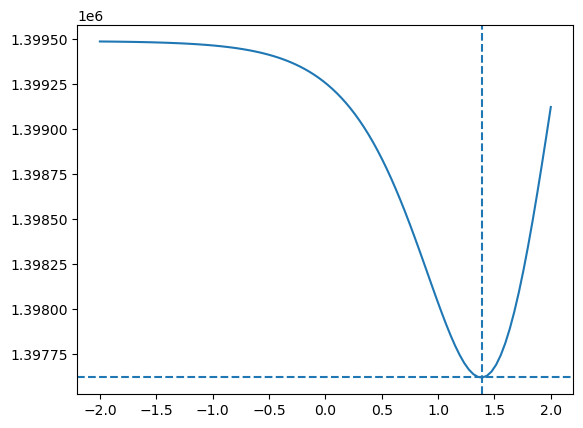

In [122]:
np.random.seed(2)

encoder = pd.get_dummies(pd.concat([train, test], axis=0), drop_first=True)
train_encoded = encoder.iloc[:len(train)]
test_encoded = encoder.iloc[len(train):]

X_train_mat = train_encoded.drop("Apps", axis=1).values
y_train_mat = train_encoded["Apps"].values

X_test_mat = test_encoded.drop("Apps", axis=1).values
y_test_mat = test_encoded["Apps"].values

alphas = np.logspace(2, -2, num=100)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True, cv=None).fit(X_train_mat, y_train_mat)
ridge_model = RidgeCV(alphas=alphas, cv=5).fit(X_train_mat,y_train_mat)

ridge_pred = ridge_model.predict(test_mat)
ridge_mse = mean_squared_error(test['Apps'], ridge_pred)

optimal_alpha = ridge_cv.alpha_
print(f"Optimal Alpha (Lambda): {optimal_alpha}")
print("MSE:", )

cv_mse_values = np.mean(ridge_cv.cv_values_, axis=0)

plt.figure()
plt.plot(np.log10(alphas), cv_mse_values)
plt.axvline(np.log10(optimal_alpha), linestyle="--")
plt.axhline(np.min(cv_mse_values), linestyle="--")
plt.show()

Q: Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

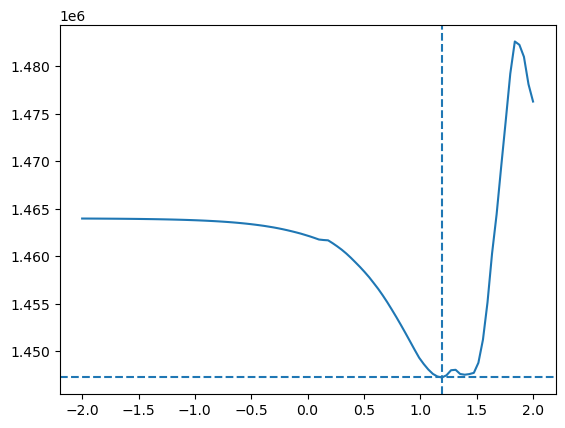

Selected Lambda: 15.556761439304715


In [123]:

scaler = StandardScaler()

train_mat = pd.get_dummies(train.drop(columns=["Apps"]), drop_first=True)
train_mat = pd.DataFrame(scaler.fit_transform(train_mat), columns=train_mat.columns)

test_mat = pd.get_dummies(test.drop(columns=["Apps"]), drop_first=True)
test_mat = pd.DataFrame(scaler.transform(test_mat), columns=test_mat.columns)

np.random.seed(4)

alphas = 10**np.linspace(2, -2, 100)
model_lasso = LassoCV(alphas=alphas, cv=5)

model_lasso.fit(train_mat, train["Apps"])

plt.figure()
plt.plot(np.log10(model_lasso.alphas_), model_lasso.mse_path_.mean(axis=1))
plt.axvline(np.log10(model_lasso.alpha_), linestyle="--")
plt.axhline(np.min(model_lasso.mse_path_.mean(axis=1)), linestyle="--")
plt.show()

selected_lambda = model_lasso.alpha_
print(f"Selected Lambda: {selected_lambda}")

In [124]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(train_mat, train['Apps'])

lasso_pred = lasso_model.predict(test_mat)

lasso_mse = mean_squared_error(test['Apps'], lasso_pred)
print(lasso_mse)

1199013.0578881872


Q: Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

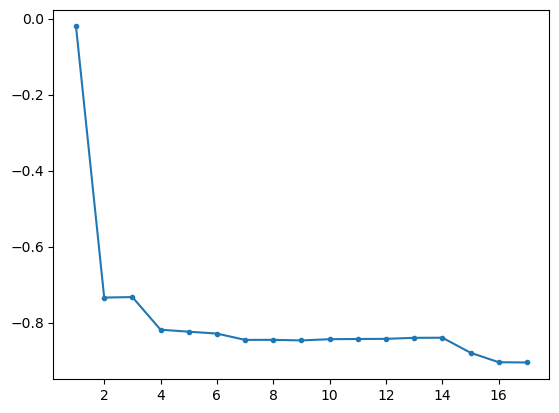

In [125]:
np.random.seed(3)

X_scaled = StandardScaler().fit_transform(X_train)

X_pca = PCA().fit_transform(X_scaled)

regression_model = LinearRegression()

cv_mse = []

n_components_range = range(1, X_pca.shape[1] + 1)
for n_components in n_components_range:
    X_pca_subset = X_pca[:, :n_components]
    mse_scores = -cross_val_score(regression_model, X_pca_subset, y_train, cv=5)
    cv_mse.append(np.mean(mse_scores))

results = pd.DataFrame({"N_Components": n_components_range, "CV_MSE": cv_mse})

plt.figure()
plt.plot(n_components_range, cv_mse, marker=".")
plt.show()

In [127]:
X_train_pca = PCA(n_components=17).fit_transform(X_scaled)  

regression_model = LinearRegression()
regression_model.fit(X_train_pca, y_train)

X_test_scaled = scaler.transform(test.drop("Apps", axis=1))
X_test_pca = pca.transform(X_test_scaled)

pcr_pred = regression_model.predict(X_test_pca)

pcr_mse = mean_squared_error(test["Apps"], pcr_pred)
print(pcr_mse)

5961141.790541545


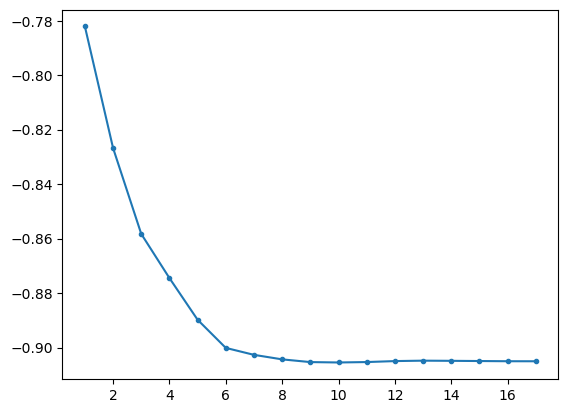

In [128]:
cv_mse = []

for n_components in range(1, X_scaled.shape[1] + 1):
    pls = PLSRegression(n_components=n_components, scale=True)
    mse_scores = -cross_val_score(pls, X_scaled, y_train, cv=5)
    cv_mse.append(np.mean(mse_scores))

results = pd.DataFrame({"N_Components": n_components_range, "CV_MSE": cv_mse})

plt.figure()
plt.plot(n_components_range, cv_mse, marker=".")
plt.show()

In [134]:
pls = PLSRegression(n_components=9, scale=True)
pls.fit(X_scaled, y)

pls_pred = pls.predict(X_test_scaled)

pls_mse = mean_squared_error(test["Apps"], pls_pred)
print(pls_mse)

1252320.11030391
